# Load Data
To show proof of concept only considering sequences shorter than 32 amino acids. Also experiments suggest to apply a sliding overlapping window of size 3 to the input seqeunces. In the sense of  NLP this artificially creates a corpus consisting of much more different words (>7000 different ngrams compared to 20 amino acids). There has been a lot of research in respresenting protein sequences as sentences of  biological words. 

(9078, 11)
2101


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


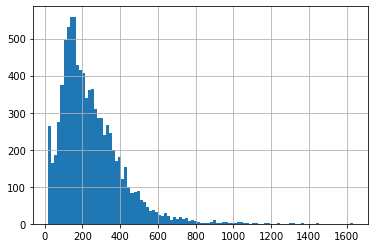

In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('/content/2018-06-06-pdb-intersect-pisces.csv')
df.len.hist(bins=100)
print(df.shape)

def seq2ngrams(seqs, n=3):
    return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs])

maxlen_seq = 128
input_seqs, target_seqs = df[['seq', 'sst3']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
input_grams = seq2ngrams(input_seqs)
print(len(input_seqs))

# Preprocessing
use preprocessing tools for text from keras to encode input sequence as word rank numbers  and target sequence as one hot. To ensure easy to use training and testing, all sequences are padded with zeros to the maximum sequence length (in our case 32).

In [10]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(input_grams)
input_data = tokenizer_encoder.texts_to_sequences(input_grams)
input_data = sequence.pad_sequences(input_data, maxlen=maxlen_seq, padding='post')

tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(target_seqs)
target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
target_data = sequence.pad_sequences(target_data, maxlen=maxlen_seq, padding='post')
target_data = to_categorical(target_data)
input_data.shape, target_data.shape

((2101, 128), (2101, 128, 4))

# Build model
This example is motivated by the NLP-task of POS-tagging. 

In [11]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional

n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

input = Input(shape=(maxlen_seq,))
x = Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq)(input)
x = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(x)
y = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = Model(input, y)
model.summary()

8301 4
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 128)          1062528   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128, 128)         98816     
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 128, 4)           516       
 tributed)                                                       
                                                                 
Total params: 1,161,860
Trainable params: 1,161,860
Non-trainable params: 0
_________________________________________________________________


# Train and evaluate model
The model is trained such that the categorical crossentropy is minimized. For evalutation also Q3-accuracy is computed, by computing the accuracy only for coding characters. 

In [12]:
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf

def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc])

X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)

model.fit(X_train, y_train, batch_size=128, epochs=25, validation_data=(X_test, y_test), verbose=1)

Epoch 1/25
10/10 [==============================] - 13s 808ms/step - loss: 1.0937 - accuracy: 0.5331 - q3_acc: 0.3591 - val_loss: 0.8366 - val_accuracy: 0.6015 - val_q3_acc: 0.4060
Epoch 2/25
10/10 [==============================] - 7s 743ms/step - loss: 0.7902 - accuracy: 0.6093 - q3_acc: 0.4270 - val_loss: 0.7348 - val_accuracy: 0.5968 - val_q3_acc: 0.3969
Epoch 3/25
10/10 [==============================] - 7s 741ms/step - loss: 0.7194 - accuracy: 0.6748 - q3_acc: 0.5224 - val_loss: 0.6759 - val_accuracy: 0.7172 - val_q3_acc: 0.5782
Epoch 4/25
10/10 [==============================] - 7s 753ms/step - loss: 0.6457 - accuracy: 0.7219 - q3_acc: 0.5919 - val_loss: 0.6337 - val_accuracy: 0.7032 - val_q3_acc: 0.5561
Epoch 5/25
10/10 [==============================] - 7s 750ms/step - loss: 0.5834 - accuracy: 0.7481 - q3_acc: 0.6301 - val_loss: 0.6278 - val_accuracy: 0.7184 - val_q3_acc: 0.5786
Epoch 6/25
10/10 [==============================] - 7s 753ms/step - loss: 0.5411 - accuracy: 0.7680

# Results
For this small example, the model trained very fast and achieves quite reasonable Q3-accuaracies. In the following three training and three testing examples are shown. Each image shows the softmax activation (red) on top of the underlying one hot ground truth (blue).

training
---
Input: APTRQPSPVTRPWQHVDAIKEALSLLNDSTDTAAVMDETVEVVSEMFDSQEPTCLQTRLELYKQGLRGSLTSLTGSLTMMASHYKKHCPPTQETSCETQIITFKSFKENLKDFLFIIPFDCWEPVQK
Target: CCCCCCCCCCCCCHHHHHHHHHHHHHHCCCCCHHHHCCEEEEECCCCCCCCCCCHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCEEEEEHHHHHHHHHHHHHHCCCCCCCCCCC
Result: CCCCCCCCCCCCCCCHHHHHHHHHHHCCCCCCCCCCCCCEEEEECCCCCCCCCHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHCCCCCCCCCEEEEEEEHHHHHHHHHHHHHCCCCCCCCCCC


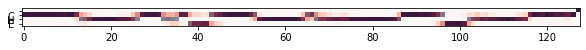

---
Input: QGQFFREIENLKEYFNASSPDVAKGGPLFSEILKNWKDESDKKIIQSQIVSFYFKLFENLKDNQVIQRSMDIIKQDMFQKFLNGSSEKLEDFKKLIQIPVDDLQIQRKAINELIKVMNDLS
Target: CCCHHHHHHHHHHHHCCCCHHHHCCCCCCHHHHHHCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCHHHHHHHHHHHHHHHCCCCHHHHHHHHHHHCCCCCCHHHHHHHHHCHHHHHHHCC
Result: CCHHHHHHHHHHHHHCCCCCHHHCCCCHHHHHHHHCCCCCCHHHHHHHHHHHHHHHHHCHCCCCCHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHCCCCCCHHHHHHHHHHHHHHHHCCC


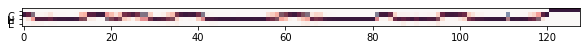

---
Input: EPAAAPAPTKEEVLLTEIRDLLKEQNNRS
Target: CCCCCCCCCHHHHHHHHHHHHHHHHHHHC
Result: CCCCCCCCCHHHHHHHHHHHHHHHHHCCC


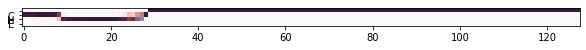

testing
---
Input: GSHMSASCGSGNFNKTAAKGVEFSAVAGDCIKYNKSSGTLQIGSWTGVASSYNITSGPQGITNTGNGWTTVANAANGDLYIKIVSASRSFNVKFDNW
Target: CCCCCCCCCCCCCCEECCCCCCEEECCCCEEEEEECCCCEEEEECCCCCEEEEECCCCCCEEECCCEEEEECCCCCEEEEEEEEEECCCEEEEEEEC
Result: CCCCCCCECCCCECCCCCCCEEEEEECCEEEEECCCCCEEEEEEEEEEEEECCCCCCCCCCCCCCCCCCEECCCCCCCEEEEEEEEECEECCCCCCC


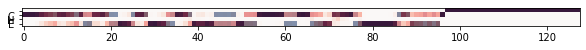

---
Input: MKKRSKARKETYSSYIYKVLKQTHPDTGISQKSMSILNSFVNDIFERIATEASKLAAYNKKSTISAREIQTAVRLILPGELAKHAVSEGTRAVTKYSSSTQA
Target: CCCCCCCCCCCCHHHHHHHHHHHCCCCEEEHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCEECHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHCCCCC
Result: CCCCCCCCCCCCHHHHHHHHHHHCCCCCCCCCCCCECCHHHHHHHHHHHHHHHHHHCHCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHCCCCCCCC


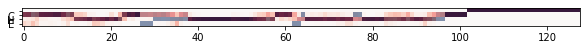

---
Input: GPSSPSVSDYTRANFGGLSEGEAQFSMTARALLDELTDLEGKLRAKLDRWDGDAQAAYWNYQKEWDAAAKDMQNVVAQLGVAIREAHDNYQAAERANTSIWAG
Target: CCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCHHHCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCCCCCC
Result: CCCCCCCCCEEECCCCCCCCCHHHHHHHHHHHHHHHHHHCCHHHHCCCCCCCCHCHCCCCCCCHHCHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCCCCC


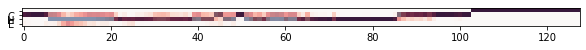

In [13]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])